In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Utilities
from PIL import Image
from IPython import display
from tqdm import tqdm # for training progress

2023-12-04 00:25:58.400397: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 00:25:58.400426: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 00:25:58.400468: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 00:25:58.408070: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 00:25:59.065446: W tensorflow/compiler/

# Parameters
Change based on system

In [2]:
EPOCHS = 30 # Do not change unless testing
BATCH_SIZE = 100 # Based on system 
DATASET_PATH = "./dataset/" # Based on system

# Paper point: Latent dim and performance
IMAGE_SHAPE = (64, 64, 3) # Should not change
LATENT_DIM = 512 # Do not change unless testing, the smaller the better

# Load Data
Done in batches

In [3]:
from keras.utils import image_dataset_from_directory

x_train, x_test = image_dataset_from_directory(
    DATASET_PATH, 
    labels=None, 
    batch_size=BATCH_SIZE, 
    image_size=IMAGE_SHAPE[:-1], 
    shuffle=False, # Don't think this matters
    validation_split=0.1, 
    subset="both",
    crop_to_aspect_ratio=True)

Found 202599 files belonging to 1 classes.
Using 182340 files for training.
Using 20259 files for validation.


2023-12-04 00:26:04.337220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 00:26:04.365503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 00:26:04.365729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
# Normalize dataset
x_train = x_train.map(lambda x: x/255)
x_test = x_test.map(lambda x: x/255)

Show a few images from the dataset

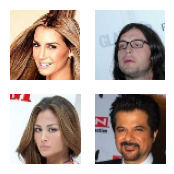

In [5]:
# Need to investigate memory usage, but should be good
train_iter, test_iter = x_train.as_numpy_iterator(), x_test.as_numpy_iterator()

fig = plt.figure(figsize=(2, 2))

plt.subplot(2, 2, 1)
plt.imshow(next(train_iter)[0]) # First image of batch 0 of x_train
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(next(train_iter)[1]) # Second image of batch 1 of x_train for variety's sakes
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(next(test_iter)[0]) # First image of batch 0 of x_test
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(next(test_iter)[1]) # Second image of batch 1 of x_test for variety's sakes
plt.axis('off')

plt.show()

# Model Definition

In [6]:
from keras import models, layers, Model

### Encoder Model

In [7]:
encoder = models.Sequential([
    layers.InputLayer(input_shape=IMAGE_SHAPE),
    layers.Conv2D(16, 3, 2, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3, 2, padding='same', activation='relu'),
    layers.Conv2D(64, 3, 2, padding='same', activation='relu'),
    layers.Conv2D(128, 3, 2, padding='same', activation='relu'),
    layers.Flatten(),
], name="face_encoder")

print("Required Latent Dim: {}".format(LATENT_DIM))
encoder.summary() # Need to have output dim of LATENT_DIMS

Required Latent Dim: 512
Model: "face_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 512)               0         
                             

### Decoder Model

In [8]:
decoder = models.Sequential([
    layers.InputLayer(input_shape=(LATENT_DIM)),
    layers.Reshape((1, 1, LATENT_DIM)),
    layers.Conv2DTranspose(64, 5, 4, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(32, 5, 4, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(16, 3, 2, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(3, 3, 2, padding='same', activation='sigmoid'),
], name="face_decoder")

decoder.summary()

Model: "face_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 1, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 64)          819264    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 4, 4, 64)          256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4, 4, 64)          0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 32)        51232     
 Transpose)                                                      
                                                      

### Deepfake Detector
Return 0 if real, 1 if fake

In [9]:
discriminator = models.Sequential([
    layers.Conv2D(3, 5, 2, padding='same', activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(32, 3, 2, padding='same', activation='relu'),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(64, 3, 2, padding='same', activation='relu'),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
], name="face_discriminator")

discriminator.summary()
# discriminator.compile(loss='binary_crossentropy', optimizer='adam')

Model: "face_discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 3)         228       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 3)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 32)          896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 flatten_1 (Flatten)         (None, 256)        

### Variational Autoencoder
Allow for the use of the Keras model API

In [10]:
class Autoencoder(Model):
  def __init__(self, encoder_model, decoder_model):
    super().__init__()
    self.encoder = encoder_model
    self.decoder = decoder_model

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  def train_step(self, data):
    train_data = (data, data) # Im too lazy to customize dataset behaviour
    return super().train_step(train_data)

  def test_step(self, data):
    test_data = (data, data) # Im too lazy to customize dataset behaviour
    return super().test_step(test_data)

autoencoder = Autoencoder(encoder, decoder)
# Paper points: loss functions
# autoencoder.compile(optimizer='adam', loss='mae')

### Convolutional Generative Adversarial Network
Also allow for the use of the Keras model API. Follow this [guide](https://keras.io/examples/generative/conditional_gan/).

In [11]:
class ConvolutionalGAN(Model):
  def __init__(self, generator_model, discriminator_model):
    super().__init__()
    self.generator = generator_model
    self.discriminator = discriminator_model
    self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
    self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

  @property
  def metrics(self):
    return [self.gen_loss_tracker, self.disc_loss_tracker]

  def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
    super().compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.d_loss_fn = d_loss_fn
    self.g_loss_fn = g_loss_fn

  def call(self, x):
    recon_image = self.generator(x)
    return recon_image

  def train_step(self, data):
    real_images = data
    batch_size = tf.shape(real_images)[0]
    # Use the generator to generate images
    generated_images = self.generator(real_images)

    # Add real images to batch
    combined_images = tf.concat(
      [generated_images, real_images], axis=0
    ) 
    # Labels for combined_images
    labels = tf.concat(
      [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
    )

    # Train the discriminator
    with tf.GradientTape() as disc_tape:
      predictions = self.discriminator(combined_images)
      d_loss = self.d_loss_fn(labels, predictions)

    # Compute gradients and update weights
    grads = disc_tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    # Train the generator
    with tf.GradientTape() as gen_tape:
      # Use the generator to generate images, must be done again to create connection
      generated_images = self.generator(real_images)
      predictions = self.discriminator(generated_images)
      # Labels if all real images
      real = tf.zeros((batch_size, 1))
      # Staggering loss function as mse is small
      g_loss = self.d_loss_fn(real, predictions) + 10*self.g_loss_fn(real_images, generated_images)

    # Compute gradients and update weights
    grads = gen_tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    # Monitor loss.
    self.gen_loss_tracker.update_state(g_loss)
    self.disc_loss_tracker.update_state(d_loss)

    return {
            "gen_loss": self.gen_loss_tracker.result(),
            "disc_loss": self.disc_loss_tracker.result(),
        }

  def test_step(self, data): # Should work out of the box
    test_data = (data, data) # Im too lazy to customize dataset behaviour
    return super().test_step(test_data)

dcgan = ConvolutionalGAN(autoencoder, discriminator)
dcgan.compile(
  d_optimizer=keras.optimizers.Adam(),
  g_optimizer=keras.optimizers.Adam(), 
  d_loss_fn = keras.losses.BinaryCrossentropy(from_logits=True),
  g_loss_fn = keras.losses.MeanAbsoluteError()
)

# Model Visualization

### Encoder

2023-12-04 00:26:06.737971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


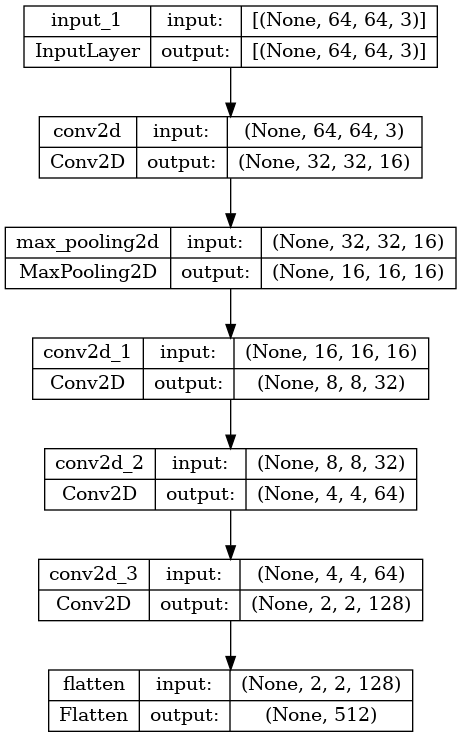

In [12]:
# Workaround, build the model using some example input
latent_var = dcgan.generator.encoder(np.expand_dims(np.ones(shape=IMAGE_SHAPE), axis=0)) 
keras.utils.plot_model(dcgan.generator.encoder, "visualization/dcgan_encoder.png", show_shapes=True)

### Decoder

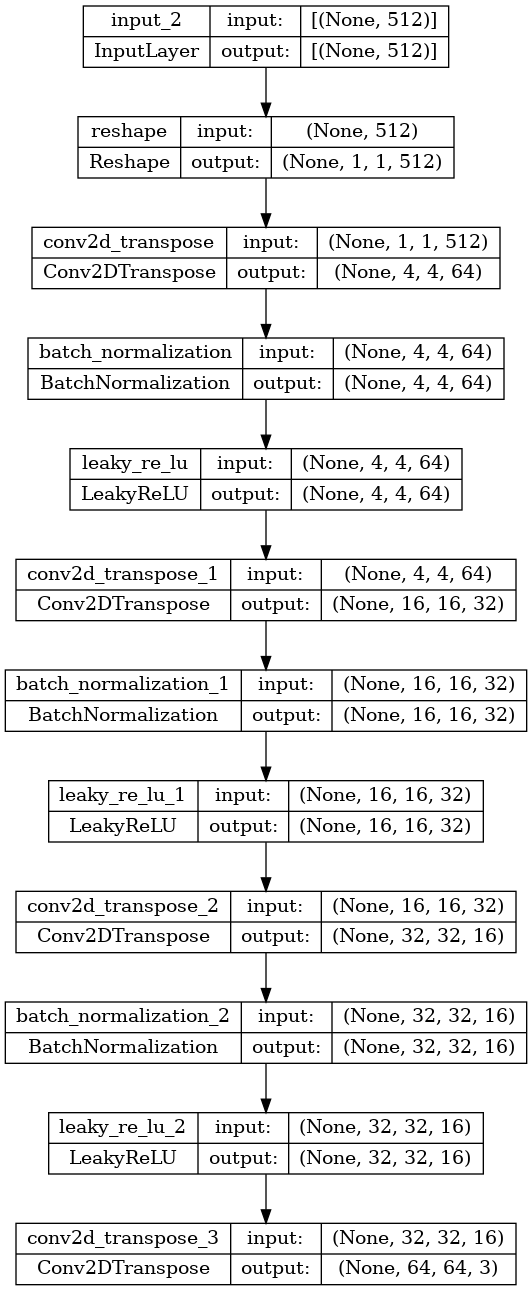

In [13]:
# Workaround, build the model using some example input
recon_image = dcgan.generator.decoder(latent_var) 
keras.utils.plot_model(dcgan.generator.decoder, "visualization/dcgan_decoder.png", show_shapes=True)

### Discriminator

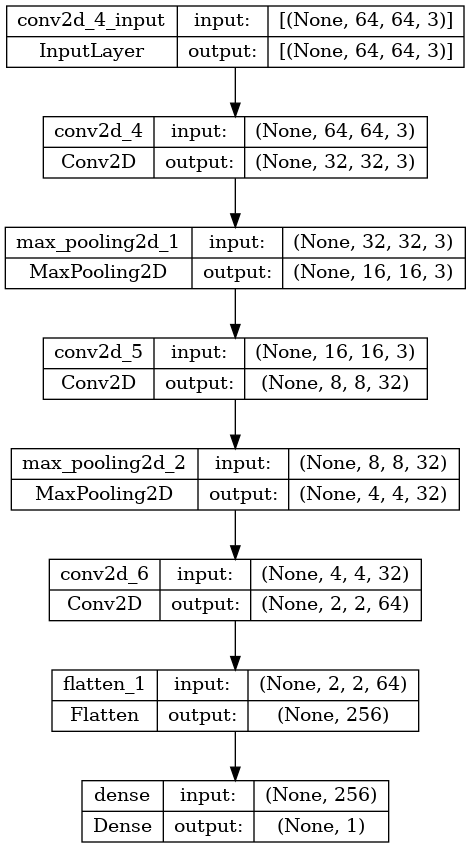

In [14]:
# Workaround, build the model using some example input
dcgan.discriminator(recon_image) 
keras.utils.plot_model(dcgan.discriminator, "visualization/dcgan_discriminator.png", show_shapes=True)

# Train Model

In [15]:
# autoencoder.fit(x_train, epochs=EPOCHS, validation_data=x_test)
history = dcgan.fit(x_train, epochs=EPOCHS)

Epoch 1/30


/home/khoa/Documents/School/CISC452/project/.venv/lib/python3.10/site-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-12-04 00:26:10.748812: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f11786e4590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-04 00:26:10.748840: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-12-04 00:26:10.752817: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-04 00:26:10.836124: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most on

1824/1824 [==============================] - 22s 9ms/step - gen_loss: 1.9967 - disc_loss: 0.6988
Epoch 2/30
1824/1824 [==============================] - 16s 9ms/step - gen_loss: 1.4621 - disc_loss: 0.6977
Epoch 3/30
1824/1824 [==============================] - 16s 9ms/step - gen_loss: 1.3903 - disc_loss: 0.6959
Epoch 4/30
1824/1824 [==============================] - 16s 9ms/step - gen_loss: 1.3535 - disc_loss: 0.6954
Epoch 5/30
1824/1824 [==============================] - 16s 9ms/step - gen_loss: 1.3295 - disc_loss: 0.6961
Epoch 6/30
1824/1824 [==============================] - 16s 9ms/step - gen_loss: 1.2944 - disc_loss: 0.6943
Epoch 7/30
1824/1824 [==============================] - 16s 9ms/step - gen_loss: 1.2924 - disc_loss: 0.6975
Epoch 8/30
1824/1824 [==============================] - 16s 9ms/step - gen_loss: 1.2709 - disc_loss: 0.6971
Epoch 9/30
1824/1824 [==============================] - 16s 9ms/step - gen_loss: 1.2432 - disc_loss: 0.6936
Epoch 10/30
1824/1824 [================

# Plot Training History

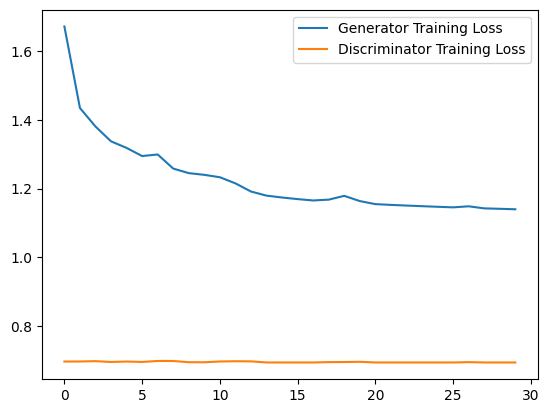

In [16]:
plt.plot(history.history["gen_loss"], label="Generator Training Loss")
plt.plot(history.history["disc_loss"], label="Discriminator Training Loss")
plt.legend()

# Test Model 

In [17]:
decoded_imgs = dcgan.generator.predict(x_test)

203/203 [==============================] - 1s 3ms/step


2023-12-04 00:34:06.293343: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 995770368 exceeds 10% of free system memory.


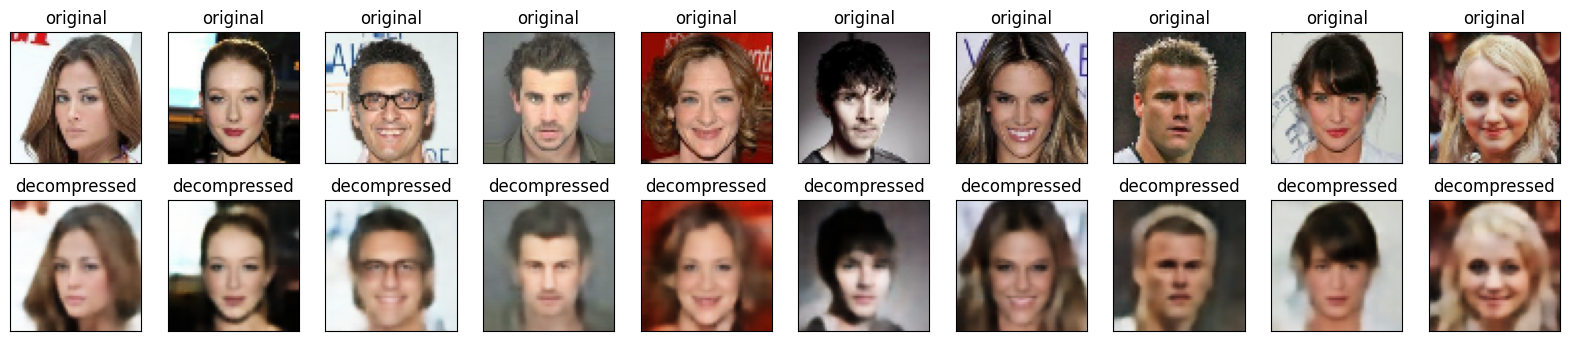

In [18]:
x_test_iterator = x_test.as_numpy_iterator()
test_batch = next(x_test_iterator)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test_batch[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("decompressed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [19]:
dcgan.generator.encoder.save('models/dcgan_encoder') # Save encoder
dcgan.generator.decoder.save('models/dcgan_decoder')

INFO:tensorflow:Assets written to: models/dcgan_encoder/assets


INFO:tensorflow:Assets written to: models/dcgan_encoder/assets


INFO:tensorflow:Assets written to: models/dcgan_decoder/assets


INFO:tensorflow:Assets written to: models/dcgan_decoder/assets
